In [52]:
import gdown

In [53]:
!gdown --id 1KmoZYmPzxrrtR4a3mSfPIumbDwf_Mrpw > /dev/null 2>&1
!gdown --id 19vK08esg9hQtD8JB-9jm7Qkck7nZ-ZqR > /dev/null 2>&1

## About the Dataset
This a YouTube comments dataset scrapped using the [YouTube Data API](https://developers.google.com/youtube/v3/docs/comments). Currently the dataset consists of roughly **1.12M** comments. The dataset can be accessed [here](https://drive.google.com/drive/folders/1-9OnYbFuiSA0M7skOYche5erzZ4Ba5Nz?usp=sharing).
<br><br>
The dataset currently has text in _English, Hindi and Hinglish_.
Please refer to the following information for an overview of the columns and the corresponding data stored within them. [Link](https://github.com/aatmanvaidya/Sentiment-Analysis-of-Online-Harassment-Towards-Women-Wrestlers/blob/scraper/attributes.txt).

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from collections import Counter
import re

In [55]:
%%time
df = pd.read_feather(r'comments_cleaned_feather.feather')

CPU times: user 893 ms, sys: 407 ms, total: 1.3 s
Wall time: 1.05 s


In [56]:
df.head()

,videoId,textDisplay,textOriginal,authorDisplayName,authorProfileImageUrl,authorChannelUrl,authorChannelId,canRate,viewerRating,likeCount,publishedAt,updatedAt,parentId,commentId
0,EBOKYsWUhvI,Dub maro jaato 😢😢.<br>Tumse tumare ladkiya nhi...,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,HECTOR OF TROY,https://yt3.ggpht.com/ytc/AOPolaQNP5bd7gNvbAas...,http://www.youtube.com/channel/UC5G8fjqoiFIqHp...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},True,none,0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,None,UgwbyvIkkAhUdaCFpcp4AaABAg
1,EBOKYsWUhvI,Haar gye bechare,Haar gye bechare,Geeta Saini,https://yt3.ggpht.com/8XmOPNrT3Vy3wr0fItlWbaMk...,http://www.youtube.com/channel/UCsMGRdH3YHrbs2...,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},True,none,0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,None,Ugyz3OwSXamho91-8I94AaABAg
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,Dhamki mili pahalwano ko aur sab manage kr liy...,Ayaan Chouhan,https://yt3.ggpht.com/ytc/AOPolaREH2WnrnbD53OI...,http://www.youtube.com/channel/UC_dWuNh6zydTHI...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},True,none,0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,None,Ugyphs1TT1Yoj7MZBVJ4AaABAg
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,Kamal,https://yt3.ggpht.com/ytc/AOPolaTRSm_dEOKj9H82...,http://www.youtube.com/channel/UCVdGObpHM-IMHB...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},True,none,1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,None,UgwnIxpuFAcKsEzffBp4AaABAg
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,Pahlwan jante h kuch nhi kr payenge uska,jagriti tiwari upp,https://yt3.ggpht.com/ytc/AOPolaRrFnzD2i3N_3rk...,http://www.youtube.com/channel/UCRkcewHFhxE5Kf...,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},True,none,0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,None,UgxjuOlDigsmuDu53J54AaABAg


In [57]:
df.shape

(1119948, 14)

In [58]:
df['textOriginal'] = df['textOriginal'].astype(str)

In [59]:
duplicate_rows = df[df.duplicated(subset='textOriginal', keep=False)]

In [60]:
len(df['textDisplay'].unique())

93475

In [61]:
# Now this is strange, the dataset doesnt have duplicate or empty rows, why is this happening? is it some datatype problem?
# Lets try to do a simple check for it again

In [62]:
%%time
count = 0
value_list = []
for index, row in df.iterrows():
    value_list.append(row['textOriginal'])
    count+=1
print(count)
print(len(value_list))

1119948
1119948
CPU times: user 39.5 s, sys: 114 ms, total: 39.6 s
Wall time: 39.9 s


In [63]:
# This means we are penetrating through the entire dataset. I dont know why pandas is doing that ://
# There is one small problem, there is a \u200b character that is present, we might have to remove that.

## Simple Slur List Frequency Count
This is a simple frequency count of how many words from the slur list are found in the data.
I have stored the results in a dictonary called _'slur_counts'_

In [64]:
with open('slur_list.txt', 'r') as file:
    slur_words = [word.strip() for word in file.readlines()]

In [65]:
len(slur_words)

506

In [66]:
slur_words_set = set(slur_words)

In [67]:
# A dictonary to count the frequency of each slur word identified
slur_counts = {}
sentence_beforeRegex_list = []

In [68]:
sentence_beforeRegex_list_set = set(sentence_beforeRegex_list)

In [69]:
'''
for text in df['textOriginal']:
    words = text.split()
    for word in words:
        if word in slur_words:
            if word in slur_counts:
                slur_counts[word] += 1
            else:
                slur_counts[word] = 1
'''
for text in df['textOriginal']:
    if text is not None:
        words = text.split()
        slur_words_in_text = set(words) & slur_words_set
        if slur_words_in_text:
            if len(sentence_beforeRegex_list_set)<=100:
                sentence_beforeRegex_list_set.add(text)
        for word in slur_words_in_text:
            if word in slur_counts:
                slur_counts[word] += 1
            else:
                slur_counts[word] = 1
# Problem with code, in set if a user has used the same word multiple times, set will dismiss that.

In [70]:
sorted_slur_counts = dict(sorted(slur_counts.items(), key=lambda item: item[1], reverse=True))

In [71]:
sorted_slur_counts
# list(sorted_slur_counts.items())[:8]

{'chutiya': 2647,
 'chutiye': 1839,
 'chod': 1788,
 'mc': 1155,
 'bsdk': 1147,
 'stupid': 994,
 'sali': 992,
 'gaddar': 981,
 'harami': 965,
 'बलात्कार': 790,
 'गद्दार': 623,
 'tatti': 499,
 'chamcha': 488,
 'fat': 482,
 'Randi': 418,
 'balatkar': 395,
 'jihadi': 383,
 'साली': 355,
 'chuda': 329,
 'हरामी': 315,
 'आतंकवादी': 295,
 'Madarchod': 270,
 'slave': 267,
 'saali': 252,
 'bai': 246,
 'halala': 245,
 'aatankwadi': 232,
 'chatukar': 228,
 'chamchi': 213,
 'ugly': 210,
 'chutia': 206,
 'चाटुकार': 188,
 '---': 157,
 'fuck': 155,
 'bhadva': 153,
 'bastard': 152,
 'Gandu': 150,
 'Gaand': 147,
 'bhenchod': 142,
 'गांड': 135,
 'mooh': 115,
 'lodu': 108,
 'burnol': 103,
 'मादरचोद': 101,
 'चमची': 99,
 'Gud': 97,
 'kutti': 93,
 'kutiya': 90,
 'सूअर': 90,
 'Maderchod': 89,
 'nasty': 83,
 'librandu': 83,
 'jihadis': 80,
 'चमचा': 76,
 'रंडी': 72,
 'दोगली': 69,
 'Gatiya': 67,
 'chakka': 67,
 'Lodu': 66,
 'चूतिये': 65,
 'chudai': 65,
 'Suar': 64,
 'जिहादी': 63,
 'bazaru': 61,
 'bhosdiwale': 59,

In [72]:
sum(sorted_slur_counts.values())

25393

In [73]:
sentence_beforeRegex_list_set

{'01:10 high Drama bsdk mutrakarita band karo tum',
 '@Arvind Chaurasia andhbhakt to tu b h--   un pehelwano & socalled kisano & sickular & leftist & gaddar  partys ka....',
 '@Deepak Kumar kya majburi thi be batana to??kuch bhi analyse matkr le khud se chu tiye.  \nagar unke pass proof hai to court jao na, road pr q ma a chuda rhe apni??',
 '@Dhaval Gite and yes i am andhbhakt can you accept that you are janmo janmantar charan chatu naak  ragdu pichvada chatu congressi chamcha',
 '@Dhaval Gite yes aur tu janmo janmantar charan chatu congressi chamcha',
 '@Nightmare Reality Haan tum jaise kutte toh mahilao ke kapde hi fat te dekhna chahte ho. Shree Ram hote toh tumhare Brijbhushan sar dhadh se alag hota.',
 '@Rahul makhija abe andbhakt wo bhushan jhoot bolrha hai\nMast khush hai ek dum sala harami',
 '@gamingonline Abey bo bina national khelke Olympic Main jana chate hain or world champion hone se kya hoga sushil kumar world champion nahin thi kya bo murder kiya tha 😂 world champion ho

In [74]:
'''
One thing is clear from this, all the explicit words that are in english are not there in the list,
this means youtube either deletes them or hides them. And the moderation for local vernacular language is weak.
'''

'\nOne thing is clear from this, all the explicit words that are in english are not there in the list,\nthis means youtube either deletes them or hides them. And the moderation for local vernacular language is weak.\n'

# Regex
What is a Regex? -> a sequence of characters that specifies a match pattern in text.

**Step 1** - Clean and Preprocess the Data
1.   Remove User Names - `r'@\w+\b'`
2.   Remove URL's and unecessary puntuation marks - `[^\w\s.]|http\S+|www\S+|https\S+`
3.  Remove Double spaces - `r'\s+', ' '`
4.  Remove any leading or trailing spaces - `.strip()`



In [75]:
text = "@user, temp, temp, ;;;;;;;; I hate the offensive and racist comments\n\n\n. They disgust me. Visit https://example.com for more information."

In [76]:
def clean_text(text):
    cleaned_text = re.sub(r'@\w+\b|[^\w\s.]|(?:https?|ftp)://\S+|www.\S+', '', text).replace('\n', '').strip()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [77]:
print(clean_text(text))

temp temp I hate the offensive and racist comments. They disgust me. Visit for more information.


In [78]:
regexDf = df[['textOriginal']]

In [79]:
# clean text
regexDf['textOriginal'] = regexDf['textOriginal'].apply(lambda x: clean_text(x))

<ipython-input-79-547ff038857b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regexDf['textOriginal'] = regexDf['textOriginal'].apply(lambda x: clean_text(x))


### Just check the count of words from the slur list ignoring case (upper or lower) of the word. We also look if any word from the slur list is present as a sub-string of any other word in the dataset.

1.   `re.findall()` - searches for all non-overlapping occurrences of a pattern in a given text.
2.   `(?i)` - make matching case-insenstive
3.  `'(' + '|'.join(slur_words) + r')'` - find a pattern that matches any of the slur words

In [80]:
skip_regex = False

In [81]:
slur_word_counts = {}
sentence_afterRegex_list = []

In [82]:
sentence_afterRegex_list_set = set(sentence_afterRegex_list)

In [83]:
search_words_women = ["women", "woman", "aurat", "ladki", "lady", "girl", "female", "wife"]
search_words_women_set = set()

In [84]:
%%time
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    # matches = re.findall(r"(?i)\b(" + '|'.join(slur_words) + r")\b", text)
    matches = re.findall(r'(?i)(' + '|'.join(slur_words) + r')', text)
    if matches:
        if len(sentence_afterRegex_list_set) <= 100:
            sentence_afterRegex_list_set.add(text)
    if matches:
        text_lower = text.lower()
        if set(text_lower) & set(search_words_women):
            if len(search_words_women_set)<=100:
                search_words_women_set.add(text)
    for match in matches:
        slur_word_counts[match] = slur_word_counts.get(match, 0) + 1

CPU times: user 7min 18s, sys: 977 ms, total: 7min 19s
Wall time: 7min 21s


In [85]:
slur_word_counts

{'ms': 13407,
 'halwa': 8551,
 'bai': 9483,
 'chut': 2591,
 'Lulli': 26,
 'simp': 1725,
 'randi': 813,
 'bsdk': 1323,
 'fuck': 697,
 'fat': 3144,
 'MC': 744,
 'chod': 7929,
 'harami': 1399,
 'FAT': 180,
 'Harami': 199,
 'motherfucker': 25,
 'chutiya': 3554,
 'mc': 3103,
 'gud': 372,
 'Chutiya': 939,
 'MS': 459,
 'Chut': 387,
 'stupid': 1372,
 'hoe': 903,
 'madarchod': 1037,
 'Simp': 376,
 'chaka': 371,
 'slims': 1596,
 'sali': 1361,
 'tatti': 512,
 'Tukde tukde gang': 130,
 'ugly': 264,
 'chakka': 1216,
 'Sali': 275,
 'chuda': 545,
 'Chod': 343,
 'lulli': 43,
 'mujra': 58,
 'gaddar': 1873,
 'Librandu': 222,
 'jihadi': 624,
 'chamcha': 819,
 'BALATKAR': 199,
 'CHUDA': 59,
 'retarded': 26,
 'Maderchod': 98,
 'CRAZY': 37,
 'gaand': 930,
 'Jihadi': 182,
 'gatiya': 303,
 'Bsdk': 456,
 'bitch': 117,
 'kutiya': 121,
 'bastard': 351,
 'balatkar': 2631,
 'chatukar': 454,
 'HALF M': 22,
 'Mc': 583,
 'Fat': 241,
 'crazy': 159,
 'aatankwadi': 325,
 'Gud': 194,
 'GADDAR': 119,
 'CHUDAIL': 21,
 'Bai

In [86]:
sum(slur_word_counts.values())

101382

In [87]:
sorted_slur_word_counts = dict(sorted(slur_word_counts.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_counts.items())[:8])

[('ms', 13407), ('bai', 9483), ('halwa', 8551), ('chod', 7929), ('chutiya', 3554), ('fat', 3144), ('mc', 3103), ('balatkar', 2631)]


In [88]:
sentence_afterRegex_list_set

{'Aaj tum sab log en medal laneh valeh en ladkiyo ko dekho...aur bas namardo ki tarah apni ghar peh bait keh en cheezo chup chap honeh do...kal tumari maa betiyo aur beheno biwi peh b ayenge bas tum namard bankeh rahna.....tum log es mahan desh ki praja ho...yeh veero ka desh hai...tumareh aage apni maa beti bahan peh shoshan hoga tho tum namardo ki tarah deko geh yah lado geh',
 'Abe wrestler ho toh kya sale kuch bhi karoge No enter Zone mein protest karoge chutiyapa ka bhi haad hota hai India gate hai bhaut sari public area hai tum log Ab medal kyn nhi fank rahe ho BC Faltu ka Darma Ab kal ko BC gun leke chalane lag jao ge aur chahte ho Police kuch na kare Rules and regulations bhi hote hai sala ajeeb chutiya log hai. Jab harassed hue tab nhi bola gaya 56 mahine baad yaad aya Bhai sab dikh raha hai Politics hai ye sab.Edit Parliament is not allowed for normal people to enter only authorised people can enter and I cant believe in comments section people are so Illiterate theyre actual

In [89]:
search_words_women_set

set()

In [90]:
# We clearly see that the amount of slur words drastically increase. Now the step ahead would be too create seperate regex for the most used slur words.
# Note - the substrings could also be a part of different words and not necessarily hateful. But given the nature of the words, I feel that chances are low.

## Create Regex for the most used Slur Words

- Lets start by looking at the word `"chutiya"`

In [91]:
text = "they called me a chhhutiyyaa and I ignored them."
# text = "abcchhutiyeexvy"

In [92]:
pattern = r'ch+h?[uo]t[iy]a?'

In [93]:
matches = re.findall(pattern, text, re.IGNORECASE)

In [94]:
matches

['chhhuti']

In [95]:
%%time
slur_word_count_2 = {}
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches = re.findall(pattern, text, re.IGNORECASE)
    for match in matches:
        slur_word_count_2[match] = slur_word_count_2.get(match, 0) + 1

CPU times: user 42.4 s, sys: 102 ms, total: 42.5 s
Wall time: 42.7 s


In [96]:
sum(slur_word_count_2.values())

9289

In [97]:
sorted_slur_word_count_2 = dict(sorted(slur_word_count_2.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_2.items())[:8])

[('chuti', 6383), ('Chuti', 1168), ('choti', 463), ('chutia', 344), ('chuty', 204), ('chutya', 201), ('chhoti', 167), ('Chutya', 90)]


In [98]:
# Okay wow, the number of words that are similar to `chutiya` increase drastically.

In [99]:
# one problem with this is, we dont know what the sentence might be directed to, to women? to the govt? to brijbhusan?
# or just some guy reply to a person in a comment?

- now lets look at `chod`

In [100]:
text_2 = "they called me a chhut, chod but I ignored them, hmpf"

In [101]:
pattern_2 = r'ch+[ou]+[dt]'

In [102]:
matches_2 = re.findall(pattern_2, text_2, re.IGNORECASE)

In [103]:
matches_2

['chhut', 'chod']

In [104]:
slur_word_count_3 = {}
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches_2 = re.findall(pattern_2, text, re.IGNORECASE)
    for match in matches_2:
        slur_word_count_3[match] = slur_word_count_3.get(match, 0) + 1

In [105]:
sum(slur_word_count_3.values())

27220

In [106]:
sorted_slur_word_count_3 = dict(sorted(slur_word_count_3.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_3.items())[:8])

[('chod', 9750), ('chut', 8219), ('chot', 1640), ('chud', 1605), ('Chut', 1474), ('chhod', 1416), ('Choud', 382), ('chhot', 371)]


- now lets do this for `bsdk`

In [107]:
text_3 = "they called me a bsssdk, I left"

In [108]:
pattern_3 = r'bs+d+k'
matches = re.findall(pattern_3, text_3, re.IGNORECASE)

In [109]:
matches

['bsssdk']

In [110]:
slur_word_count_4 = {}
for index, row in regexDf.iterrows():
    text = row['textOriginal']
    matches = re.findall(pattern_3, text, re.IGNORECASE)
    for match in matches:
        slur_word_count_4[match] = slur_word_count_4.get(match, 0) + 1

In [111]:
sum(slur_word_count_4.values())

1836

In [112]:
sorted_slur_word_count_4 = dict(sorted(slur_word_count_4.items(), key=lambda item: item[1], reverse=True))
print(list(sorted_slur_word_count_4.items())[:8])

[('bsdk', 1323), ('Bsdk', 456), ('Bssdk', 32), ('BSDK', 25)]


- now lets try for a hindi word -

some links that help me understand this better
- https://stackoverflow.com/questions/41356013/how-to-detect-if-a-string-contains-hindi-devnagri-in-it-with-character-and-wor
- https://stackoverflow.com/questions/14859957/regular-expressions-with-indian-characters
- https://unicode.org/charts/PDF/U0900.pdf

## Lets now look at the impact regex has had on counting the slur words in the data

The slur list has 506 words consisting of different languages.

|        **Word**       | **Before Regex** |     **After Regex**     |
|:---------------------:|:----------------:|:-----------------------:|
| Simple Count of Words |      25,393      | 101,382 (just  english) |
|        chutiya        |       2,647      |          9,289          |
|          chod         |       1,788      |          12,749         |
|          bsdk         |       1,147      |          1,836          |


- what are the 100 senteces which use the slur words before and after regex?
- look at the slur count vs timeline

### Looking at use of slur_words accross the timeline.

In [113]:
# to include the hindi words, lets just to a simple check versus time.

In [114]:
timeDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

In [115]:
timeDf.head()

,videoId,textOriginal,authorChannelId,likeCount,publishedAt,updatedAt,commentId
0,EBOKYsWUhvI,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,UgwbyvIkkAhUdaCFpcp4AaABAg
1,EBOKYsWUhvI,Haar gye bechare,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,Ugyz3OwSXamho91-8I94AaABAg
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,Ugyphs1TT1Yoj7MZBVJ4AaABAg
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,UgwnIxpuFAcKsEzffBp4AaABAg
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,UgxjuOlDigsmuDu53J54AaABAg


In [116]:
# some cleaning (Acutally a LOT!!)
header = np.array(timeDf.columns)
timeDf = timeDf[~np.all(timeDf.values == header, axis=1)]
timeDf = timeDf[~timeDf['videoId'].str.contains(r'\bvideoId\b', case=False, regex=True)]
pattern = r'^\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}Z$'
timeDf = timeDf[timeDf['publishedAt'].str.contains(pattern)]

In [117]:
%%time
# Convert time from  ISO 8601 to a datetime object
timeDf['NewDateTime'] = pd.to_datetime(timeDf['publishedAt'])

CPU times: user 298 ms, sys: 2 ms, total: 300 ms
Wall time: 305 ms


In [118]:
# Convert datetime object to week, month and day
timeDf['week'] = timeDf['NewDateTime'].dt.week
timeDf['day'] = timeDf['NewDateTime'].dt.day
timeDf['month'] = timeDf['NewDateTime'].dt.month

<ipython-input-118-24104e6ccdd9>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  timeDf['week'] = timeDf['NewDateTime'].dt.week


In [119]:
# The protests started on Jan 18, 2023
# https://indianexpress.com/article/sports/sport-others/wrestlers-protest-timeline-from-jantar-mantar-sit-in-to-nearly-immersing-medals-in-ganga-8649894/

In [120]:
slur_words_set = set(slur_words)

In [121]:
%%time
slurWordDf = timeDf[timeDf['textOriginal'].str.contains('|'.join(slur_words_set))]

CPU times: user 1min 10s, sys: 141 ms, total: 1min 10s
Wall time: 1min 11s


In [122]:
slur_word_counts = slurWordDf.groupby('week').size()

In [123]:
# slur_word_counts

In [124]:
pattern = r'(?i)(' + '|'.join(slur_words_set) + r')'

In [125]:
compiled_pattern = re.compile(pattern, re.IGNORECASE)

In [126]:
%%time
# counts2 = timeDf.groupby('week')['textOriginal'].apply(lambda x: x.str.contains(pattern, case=False).sum())
counts2 = timeDf.groupby('week')['textOriginal'].apply(lambda x: x.str.contains(compiled_pattern).sum())

<timed exec>:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


CPU times: user 4min 38s, sys: 528 ms, total: 4min 38s
Wall time: 4min 39s


In [127]:
'''
Lets plot the frequceny of slur words used vs time (week)
The week number denoted in the plot is the number of the week in the year (out of 52)
Week 17 - Apr. 24, 2023 - a day after protests started outside jantar mantar
Week 22 - May 29, 2023 -  Delhi Police detains top wrestlers
          May 30, 2023 - The wrestlers, hurt by the way the police had detained them and then filed FIRs against them,
                            announce they will go to Har Ki Pauri in Haridwar to 'immerse their medals' in the River Ganga.
Week 28 - July 10, 2023 - last day till I scrapped the data
'''

"\nLets plot the frequceny of slur words used vs time (week)\nThe week number denoted in the plot is the number of the week in the year (out of 52)\nWeek 17 - Apr. 24, 2023 - a day after protests started outside jantar mantar\nWeek 22 - May 29, 2023 -  Delhi Police detains top wrestlers\n          May 30, 2023 - The wrestlers, hurt by the way the police had detained them and then filed FIRs against them,\n                            announce they will go to Har Ki Pauri in Haridwar to 'immerse their medals' in the River Ganga.\nWeek 28 - July 10, 2023 - last day till I scrapped the data\n"

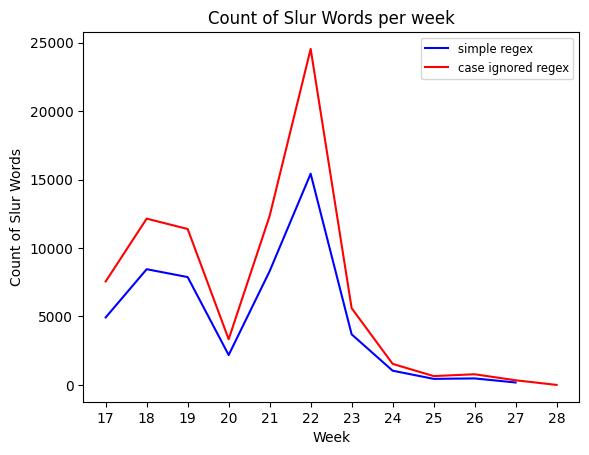

In [128]:
plt.plot(slur_word_counts.index[1:], slur_word_counts.values[1:], color='blue', label='simple regex')
plt.plot(counts2.index[8:], counts2.values[8:], color='red', label='case ignored regex')

plt.xlabel('Week')
plt.ylabel('Count of Slur Words')
plt.title('Count of Slur Words per week')
plt.xticks(counts2.index[8:])
plt.legend(loc='best', fontsize='small')
plt.show()

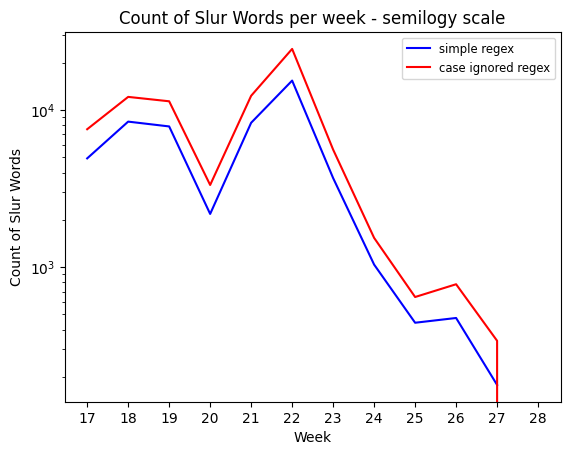

In [129]:
plt.semilogy(slur_word_counts.index[1:], slur_word_counts.values[1:], color='blue', label='simple regex')
plt.semilogy(counts2.index[8:], counts2.values[8:], color='red', label='case ignored regex')
plt.xlabel('Week')
plt.ylabel('Count of Slur Words')
plt.title('Count of Slur Words per week - semilogy scale')
plt.xticks(counts2.index[8:])
plt.legend(loc='best', fontsize='small')
plt.show()

In [130]:
# the pattern pretty much remains the same, only the count of slur words are increasing

In [131]:
# Lets now look at the like counts accross the timeline of these hateful tweets.

In [132]:
word_likes_per_week = {}

In [133]:
timeDf['likeCount'] = timeDf['likeCount'].astype(int)

In [134]:
from collections import defaultdict

In [135]:
%%time
for index, row in timeDf.iterrows():
    text = row['textOriginal']
    week = row['week']
    like_count = row['likeCount']
    matches = compiled_pattern.findall(text)
    for word in matches:
        if week not in word_likes_per_week:
            word_likes_per_week[week] = 0
        word_likes_per_week[week] += like_count

CPU times: user 5min 55s, sys: 920 ms, total: 5min 56s
Wall time: 5min 59s


In [136]:
word_likes_per_week

{27: 27,
 26: 639,
 25: 89,
 24: 366,
 23: 2006,
 22: 13568,
 21: 3911,
 19: 2048,
 18: 4532,
 17: 4434,
 3: 629,
 20: 451,
 4: 24}

In [137]:
x = sorted(word_likes_per_week.keys())
y = [word_likes_per_week[week] for week in x]

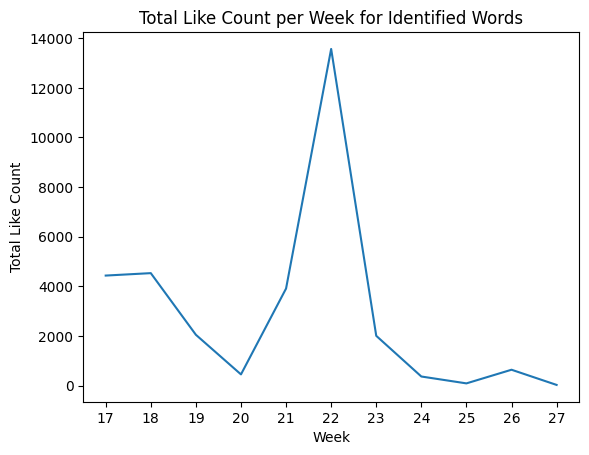

In [138]:
plt.plot(x[2:], y[2:])
plt.xlabel('Week')
plt.ylabel('Total Like Count')
plt.title('Total Like Count per Week for Identified Words')
plt.xticks(x[2:])
plt.show()

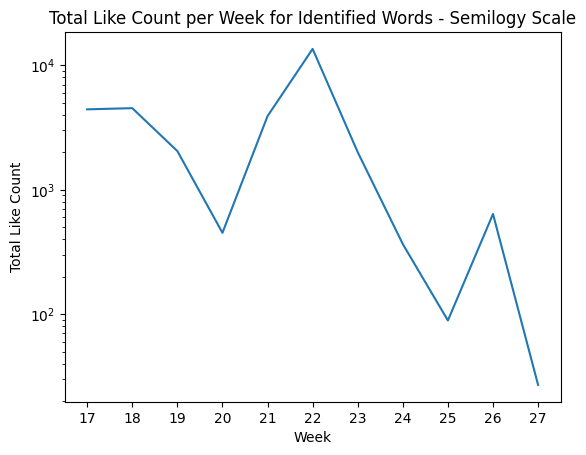

In [139]:
plt.semilogy(x[2:], y[2:])
plt.xlabel('Week')
plt.ylabel('Total Like Count')
plt.title('Total Like Count per Week for Identified Words - Semilogy Scale')
plt.xticks(x[2:])
plt.show()

In [140]:
# These plots could be showing these results because it could be also from the bias in dataset sampling.

In [141]:
'''
check if these hateful tweets are replies or not too
'''

'\ncheck if these hateful tweets are replies or not too\n'

## Identify Text Language

In [142]:
#supressing output
# !pip install inltk==0.9 > /dev/null 2>&1
# !pip install --upgrade fastai > /dev/null 2>&1

In [143]:
!pip install polyglot==16.7.4 > /dev/null 2>&1
!pip install PyICU > /dev/null 2>&1
!pip install pycld2 > /dev/null 2>&1

In [144]:
# Use iNLTK, Indic NLP Library or polyglot
# from inltk.inltk import identify_language, reset_language_identifying_models
from polyglot.detect import Detector
# languages supported by polyglot - https://polyglot.readthedocs.io/en/latest/Detection.html#supported-languages

In [145]:
# text = 'आप कैसे हैं?' text = 'તમે કેમ છો' text = 'எப்படி இருக்கிறீர்கள்' text = 'സുഖമാണോ' text = 'तू कसा आहेस'
text_sample = 'आप कैसे हैं?'

In [146]:
detector = Detector(text_sample)
print(detector.language)
print(detector.language.code)

name: Hindi       code: hi       confidence:  96.0 read bytes:  1638
hi


In [147]:
langDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

In [148]:
%%time
langDf['textOriginal'] = langDf['textOriginal'].apply(lambda x: clean_text(x))

CPU times: user 15.9 s, sys: 464 ms, total: 16.3 s
Wall time: 20.1 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [149]:
langDf['language'] = 'dnd' # dnd - did not detect

<ipython-input-149-94e6cd841e46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  langDf['language'] = 'dnd' # dnd - did not detect


In [150]:
# langDf.head()

In [151]:
import warnings
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="polyglot")

In [152]:
# %%time
# for index, row in langDf.iterrows():
#     text = row['textOriginal']
#     try:
#         detector = Detector(text)
#         detected_language = detector.language.code
#         langDf.at[index, 'language'] = detected_language
#     except:
#         # If an error occurs or language detection fails, keep the 'dnd' value
#         # An error could also occur if text length is small
#         pass

## Running the Seintiment Analysis Model

In [153]:
!pip install transformers > /dev/null 2>&1
!pip install --upgrade accelerate > /dev/null 2>&1
# !pip install xformers > /dev/null 2>&1

In [154]:
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

In [155]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

In [156]:
# sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
# sentiment_task("I am very happy today")

In [157]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [158]:
text = "Covid cases are increasing fast!"

In [159]:
def apply_sentiment_analysis(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.exp(scores) / np.exp(scores).sum()
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    label = config.id2label[ranking[0]]
    score = scores[ranking[0]]
    return label, score

In [160]:
label, score = apply_sentiment_analysis(text)
print(f"{label}, {score}")

negative, 0.7235767245292664


In [161]:
sentimentDf = df[['videoId','textOriginal','authorChannelId', 'likeCount', 'publishedAt', 'updatedAt', 'commentId']]

In [162]:
sentimentDf2 = sentimentDf.head(5000)

In [163]:
sentimentDf2.shape

(5000, 7)

In [164]:
sentimentDf2['label'] = ""
sentimentDf2['score'] = 0.0

<ipython-input-164-11ed32de50ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentimentDf2['label'] = ""
<ipython-input-164-11ed32de50ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentimentDf2['score'] = 0.0


In [165]:
sentimentDf2.head()

,videoId,textOriginal,authorChannelId,likeCount,publishedAt,updatedAt,commentId,label,score
0,EBOKYsWUhvI,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,UgwbyvIkkAhUdaCFpcp4AaABAg,,0.0
1,EBOKYsWUhvI,Haar gye bechare,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,Ugyz3OwSXamho91-8I94AaABAg,,0.0
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,Ugyphs1TT1Yoj7MZBVJ4AaABAg,,0.0
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,UgwnIxpuFAcKsEzffBp4AaABAg,,0.0
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,UgxjuOlDigsmuDu53J54AaABAg,,0.0


In [166]:
%%time
# for index, row in sentimentDf2.iterrows():
#     text = row['textOriginal']
#     label, score = apply_sentiment_analysis(text)
#     row['label'] = label
#     row['score'] = score

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [167]:
sentimentDf2.head()

,videoId,textOriginal,authorChannelId,likeCount,publishedAt,updatedAt,commentId,label,score
0,EBOKYsWUhvI,Dub maro jaato 😢😢.\nTumse tumare ladkiya nhi b...,{'value': 'UC5G8fjqoiFIqHpKyVeOTsFg'},0,2023-07-06T07:04:02Z,2023-07-06T07:04:02Z,UgwbyvIkkAhUdaCFpcp4AaABAg,,0.0
1,EBOKYsWUhvI,Haar gye bechare,{'value': 'UCsMGRdH3YHrbs21NOraRuyQ'},0,2023-07-03T22:21:37Z,2023-07-03T22:21:37Z,Ugyz3OwSXamho91-8I94AaABAg,,0.0
2,EBOKYsWUhvI,Dhamki mili pahalwano ko aur sab manage kr liy...,{'value': 'UC_dWuNh6zydTHIRr6hi3Omg'},0,2023-07-03T05:06:33Z,2023-07-03T05:06:33Z,Ugyphs1TT1Yoj7MZBVJ4AaABAg,,0.0
3,EBOKYsWUhvI,Jaato pr ye boj rhega ki vo apni hi vyavstha s...,{'value': 'UCVdGObpHM-IMHB_b7_K-7rA'},1,2023-07-02T03:39:50Z,2023-07-02T03:39:50Z,UgwnIxpuFAcKsEzffBp4AaABAg,,0.0
4,EBOKYsWUhvI,Pahlwan jante h kuch nhi kr payenge uska,{'value': 'UCRkcewHFhxE5KfLHrLx0wpA'},0,2023-06-28T15:10:36Z,2023-06-28T15:10:36Z,UgxjuOlDigsmuDu53J54AaABAg,,0.0
